In [39]:
# Importing (using/include) packages and files needed for the code to run
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using SpecialFunctions
using Roots
using NLsolve
using Printf
using HDF5
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("GridOperations.jl")
include("Topo.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Stefan Problem - test melting and solidification

Step 1 - import packages

Step 2 - Define a function that relates entropy and temperature/pressure. 
$$
T = f_1(P,S)
$$

$$
T = \exp \left( \frac{S}{C_V} + \ln (T_{ref}) - \frac{\Delta H_{fus} }{C_V T_M}X \right)
$$

and 
$$
S = f_2(P,T)
$$
$$
S = C_V (\ln (T) - \ln(T_{ref})) + \frac{\Delta H_{fus}}{T_m}X
$$

In [40]:
# functions that relates entropy and temperature/pressure are define in TemperatureEntropy.jl file
include("TemperatureEntropy.jl")

subgridSdiff! (generic function with 1 method)


Step 3 - Write functions to set up the initial condition for the Stefan problem

- Consider a box with width 100 km and height 100 km.
- The box is filled entirely with one material
- Initially, the top 10 km is solid and the bottom 90 km is liquid.
- The sides are insulating
- Density is constant and equal to 1000 kg/m$^3$
- The surface is at T=100K, the bottom is at T=273 K
- The liquid is isothermal with $T=T_m$.
- The solid has initial $T(z)$ given by the Stefan solution (Turcotte and Schubert section 4.18)
$$
\theta = \frac{erf(\eta)}{erf(\lambda_1)}
$$
- Given the initial temperature, compute initial entropy S on the markers.
  

In [41]:
function initial_ice_depth(x::Float64,options::Dict)
    return options["ym"] + options["amplitude"]*options["height"]*cos(pi*x/options["width"])
end 

struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    function Materials()
        new([0.0],[1e3],[0.0],[2.1e3],[2.2])
    end    
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/molK)
    melting_point_viscosity = 1e14
    viscosity = melting_point_viscosity*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e20
    lowerlimit = melting_point_viscosity
    if viscosity < lowerlimit
        viscosity = lowerlimit
    elseif viscosity > upperlimit
        viscosity = upperlimit
    end
    return viscosity
end

function update_marker_prop!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    X = markers.scalarFields["X"]
    S = markers.scalarFields["S"]
    eta = markers.scalarFields["eta"]
    mmat = markers.integers[markers.integerFields["material"],:]
    Threads.@threads for i in 1:markers.nmark
        if markers.scalars[X,i] > 0.5
            markers.scalars[rho,i] = options["density of water"]
            markers.scalars[eta,i] = 1e12
        else
            markers.scalars[rho,i] = options["density of water"]
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_T_X!(markers::Markers,materials::Materials,options::Dict)
    T = markers.scalarFields["T"]
    X = markers.scalarFields["X"]
    S = markers.scalarFields["S"]    
    mmat = markers.integers[markers.integerFields["material"],:]
    Threads.@threads for i in 1:markers.nmark
        markers.scalars[T,i],markers.scalars[X,i] = compute_T_X_from_S((markers.scalars[S,i]),options)
    end
end

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    S = markers.scalarFields["S"]
    X = markers.scalarFields["X"]
    T = markers.scalarFields["T"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    rho = markers.scalarFields["rho"]
    eta = markers.scalarFields["eta"]
    
    # Setting up Stefan conidtion
    # lambda1 = get_lambda1(options)
    # t = get_t(lambda1,options)
    
    # Note: the melt fraction is defining our layers or ice and water.
    # water - X = 1.0 
    # ice - X = 0.0
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx,options)
        
        if my > hice # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = options["Tm"]
            markers.scalars[X,i] = 1.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)
            markers.scalars[rho,i] = materials.rho0[1]
            markers.scalars[eta,i] = 1e14
        elseif my < hice # icy shell
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = options["To"] + (options["Tm"]-options["To"])/hice*my#stefan_initial_condition(get_theta(my,t,lambda1),options)
            markers.scalars[X,i] = 0.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)
            markers.scalars[rho,i] = materials.rho0[1]
            markers.scalars[eta,i] = 1e14
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + ((grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j]))*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

get_interface (generic function with 1 method)

# Main part of code
- At each timestep, begin by computing T(S,X) on the markers
- Iteratively solve the temperature equation. Start with a guess S_new = S_old
    - For T_new, compute $q_{cond} = \nabla \cdot (k \nabla T_{new})$
    - Solve diffusion equation for S_new
    - Given S_new, update T_new
    - Iterate until converged...
- Given the new entropy solution on the cell centers, update the entropy and melt fraction on the markers.

  0.202503 seconds (1.80 M allocations: 27.652 MiB, 24.19% gc time)
Writing visualization file = max_debug14/markers.-001.vtp
  0.000738 seconds (2 allocations: 1.373 MiB)
1:1:0.0:dt=4.536e7
amplitude ratio=0.9971632386040601
2:1:0.0:dt=5.4432e7
amplitude ratio=0.9969966780821098
3:1:0.0:dt=6.53184e7
amplitude ratio=0.9968636816484819
4:1:0.0:dt=7.838208e7
amplitude ratio=0.9967575674445849
5:1:0.0:dt=9.4058496e7
amplitude ratio=0.9966724883883193
6:1:0.0:dt=1.128701952e8
amplitude ratio=0.9966041397719586
7:1:0.0:dt=1.3544423424e8
amplitude ratio=0.9965490237542978
8:1:0.0:dt=1.62533081088e8
amplitude ratio=0.9965043423871341
9:1:0.0:dt=1.950396973056e8
amplitude ratio=0.9964678742122133
10:1:0.0:dt=2.3404763676671997e8
amplitude ratio=0.9964378450722966
Writing visualization file = max_debug14/markers.0000.vtp
  0.000482 seconds (2 allocations: 1.373 MiB)
11:1:0.0:dt=2.8085716412006396e8
amplitude ratio=0.9964128279621173
12:1:0.0:dt=3.370285969440767e8
amplitude ratio=0.996391662686

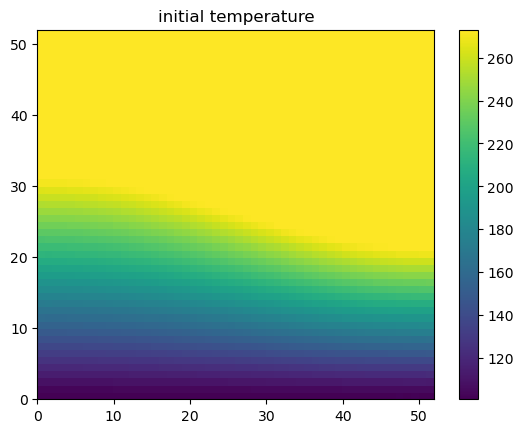

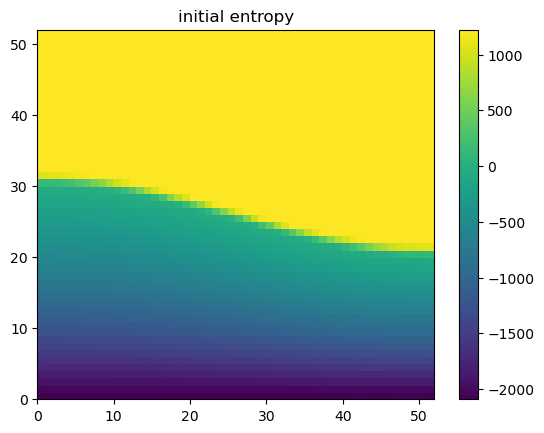

In [46]:
# Set options:
options = Dict()
options["latent heat of fusion"] = 3.34e5 #J/kg
options["specific heat of ice"] = 2.1e3 # J/kg*K (ice)
options["density of ice"] = 917 # kg/m^3
options["density of water"] = 1000.
options["thermal conductivity of ice"] = 2.2 # W/m*K
options["thermal diffusivity"] = options["thermal conductivity of ice"] / (options["density of ice"]*options["specific heat of ice"]) # m^2/s

options["Tm"] = 273.0 # K
options["To"] = 100.0 # K
# options["ym"] = 1e3 # m
options["width"] = 2e4
options["height"] = 2e4
options["ym"] = options["height"]/2
options["wavelength"] = options["width"]
options["amplitude"] = 0.1
output_dir = "max_debug14"

#
# Initialize the problem
#
W = options["width"]
H = options["height"]
ny = 51
nx = Int64( ceil(W/H*ny) )
gx = 0.0
gy = 0.113
markx = 6
marky = 6
seconds_in_year = 3.15e7

materials = Materials()
mygrid = CartesianGrid(W,H,nx,ny)
markers = Markers(mygrid,["alpha","T","rho","Cp","Hr","kThermal","S","X","eta"],["material"] ; nmx=markx,nmy=marky,random=true)
@time initial_conditions!(markers,materials,options)

Tbctype = [-1,-1,1,1] #left, right, top, bottom
Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.


# compute lambda1 (see Turcotte and Schubert chapter on Stefan Problem) and the
# time corresponding to the initial ice shell thickness
lambda1 = get_lambda1(options)
ttmp = get_t(lambda1,options)

rho_c,Hr,kThermal, = marker_to_stag(markers,mygrid,["rho","Hr","kThermal",],"center")
kThermal_vx, = marker_to_stag(markers,mygrid,["kThermal",],"vx")
kThermal_vy, = marker_to_stag(markers,mygrid,["kThermal",],"vy")

# initialize arrays to hold quantities for plotting
ocean_ice_interface = []
append!(ocean_ice_interface,options["ym"])
plot_time = []
append!(plot_time,0.0)

# at the beginning of the computation, interpolate from the markers to the nodes and back.
Xlast,Tlast = marker_to_stag(markers,mygrid,["X","T"],"center")
rhoT = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["T"],:]
Slast, = marker_to_stag(markers,mygrid,["S"],"center")#,extra_weight=rhoT)
#cell_center_to_markers!(markers,mygrid,Slast,"S")
#update_marker_T_X!(markers,materials,options)

initial_topography = get_interface(mygrid,-Xlast,-0.5)
topography = []
append!(topography,[initial_topography,])
initial_amplitude = maximum(initial_topography)-minimum(initial_topography)
#
# Output initial conditions
#
iout = -1        
        if !(isdir(output_dir))
            mkdir(output_dir)
        end
        name1 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
        println("Writing visualization file = ",name1)
        visualization(markers,0.0/seconds_in_year;filename=name1)                    
        
        name2 = @sprintf("%s/nodal_fields.%04d.vtr",output_dir,iout)
        output = Dict( "S"=>Slast[2:ny,2:nx],"X"=>Xlast[2:ny,2:nx],"T"=>Tlast[2:ny,2:nx])
        visualization(mygrid,output,0.0/seconds_in_year,filename=name2)
iout += 1        
#
# Plot initial conditions
#
figure()
pcolor(Tlast)
title("initial temperature")
colorbar()
show()
figure()
pcolor(Slast)
colorbar()
title("initial entropy")
show()
T0 = copy(Tlast)
S0 = copy(Slast)
# 
# Initialize variables so that they persist outside of time-stepping loop
#
time = 0.0

vx = nothing
vy = nothing
eta_s = nothing
eta_n = nothing
rho_vx = nothing
rho_vy = nothing
Xnew = nothing
Snew = nothing
dt = seconds_in_year
terminate = false
#
# Main time-stepping loop
#
for itime in 1:1000
    Xlast,Tlast = marker_to_stag(markers,mygrid,["X","T"],"center")
    rhoT = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["T"],:]
    Slast, = marker_to_stag(markers,mygrid,["S"],"center",extra_weight=rhoT)

    rho_vx, = marker_to_stag(markers,mygrid,["rho",],"vx")
    rho_vy, = marker_to_stag(markers,mygrid,["rho",],"vy")
    eta_s, = marker_to_stag(markers,mygrid,["eta",],"basic",method="harmonic")
    eta_n, = marker_to_stag(markers,mygrid,["eta",],"center",method="harmonic")
    
    # Assembling and solving the stokes equations
    vxc = nothing
    vyc = nothing
    for i=1:(itime==1 ? 2 : 1) # for first timestep, iterate twice to get timestep for free surface stabilization.
        L,R = form_stokes(mygrid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)# uses the previous timestep dt
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,mygrid;ghost=true)
        vxc,vyc = velocity_to_centers(mygrid,vx,vy)
    
        dt_stokes = compute_timestep(mygrid,vxc,vyc;dtmax=Inf,cfl=0.1)
        dt_diffusion = calculate_diffusion_timestep(mygrid,options)
        dt = min(dt_stokes,dt_diffusion,1.2*dt)
    end    
        
    Snew = copy(Slast)
    Tnew = copy(Tlast)
    Xnew = copy(Xlast)
    for titer in 1:2
        # Using Tlast yields an explicit scheme
        q_vx,q_vy = compute_q_cond(mygrid,Tlast,kThermal_vx,kThermal_vy) # W/m^2
        # Using Tlast yields an explicit scheme
        Snew = compute_S_new(mygrid,Tlast,rho_c,Hr,q_vx,q_vy,Slast,dt)
        Tnew,Xnew = update_T_X_from_S(Snew,options)             
        Tnew,Xnew,Snew = ghost_nodes_center_TXS(mygrid,Tnew,Xnew,Snew,Tbctype,Tbcval,options)
        residual = compute_entropy_residual(mygrid,Tlast,rho_c,Hr,q_vx,q_vy,Slast,Snew,dt)
        Snorm = norm( residual[2:ny,2:nx] )
        
        if Snorm < 1e-12
            println(itime,":",titer,":",Snorm,":dt=",dt)    
            break
        elseif titer == 2
            println("failed to converge")
            break
        end
    end
    
    dS = Snew - Slast
    # compute the subgrid entropy change
    #dS_subgrid_node = subgirdSdiff!( mygrid,markers,Slast,dt,options,diffusivity=1.0 )
    dS_remaining = dS#-dS_subgrid_node
    
    cell_center_change_to_markers!(markers,mygrid,dS_remaining,"S")
    update_marker_T_X!(markers,materials,options)

    #interface = get_interface(mygrid,-Snew,-611.0)
    interface = get_interface(mygrid,-Xnew,-0.5)
    append!(ocean_ice_interface,mean(interface))
    amplitude = maximum(interface)-minimum(interface)
    
    # advance to next timestep
    Slast = copy(Snew)
    Xlast = copy(Xnew)
    Tlast = copy(Tnew)

    append!(topography,[interface,])

    println("amplitude ratio=",amplitude/initial_amplitude)
    # termination criteria
    if amplitude/initial_amplitude < exp(-1.0)
        terminate = true
    end
    
    if mod(itime,10) == 0 || terminate
        if iout == 0 && !(isdir(output_dir))
            mkdir(output_dir)
        end
        name1 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
        println("Writing visualization file = ",name1)
        visualization(markers,time/seconds_in_year;filename=name1)                    
        
        name2 = @sprintf("%s/nodal_fields.%04d.vtr",output_dir,iout)
        vn = velocity_to_basic_nodes(mygrid,vxc,vyc)
        output = Dict( "S"=>Snew[2:ny,2:nx],"X"=>Xnew[2:ny,2:nx],"T"=>Tnew[2:ny,2:nx],"velocity"=>vn)
        visualization(mygrid,output,time/seconds_in_year,filename=name2)
        
        iout+=1 
    end
    if terminate
        break
    end

    # advect markers and move to next time step
    move_markers_rk4!(markers,mygrid,vx,vy,dt,continuity_weight=1/3)
    
    time += dt
    append!(plot_time,time)
end

11237.414147484362


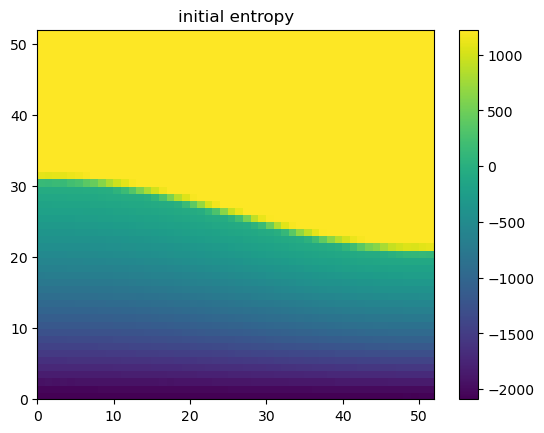

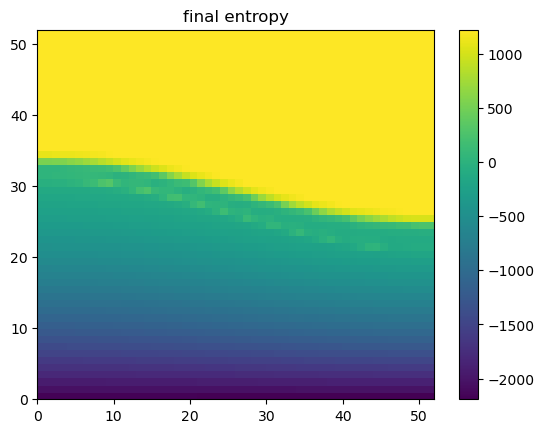

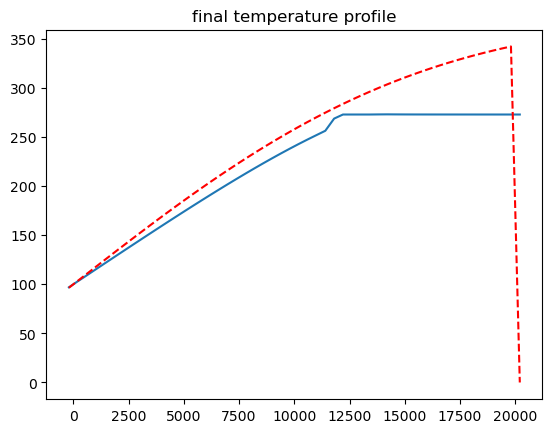

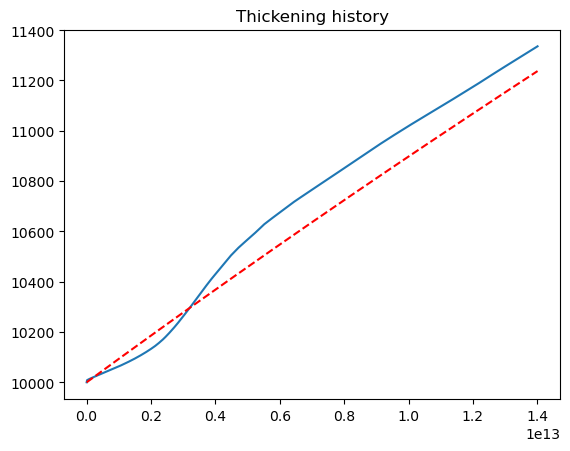

In [45]:
figure()
pcolor(S0)
colorbar()
title("initial entropy")
show()

figure()
pcolor(Slast)
colorbar()
title("final entropy")
show()

figure()
plot(mygrid.yc,Tlast[:,2])
title("final temperature profile")

final_time = ttmp + time
stefan_solution = zeros(ny+1,1)
for j in 1:mygrid.ny
    stefan_solution[j] = stefan_initial_condition( get_theta(mygrid.yc[j],final_time,lambda1),options)
end
plot(mygrid.yc,stefan_solution,"r--")
show()

yfinal = get_y.(lambda1,final_time,Ref(options))
println(yfinal)

figure()
plot(plot_time,ocean_ice_interface)
yfinal = get_y.(lambda1,plot_time .+ ttmp,Ref(options))
plot(plot_time,yfinal,"r--")
title("Thickening history")
show()

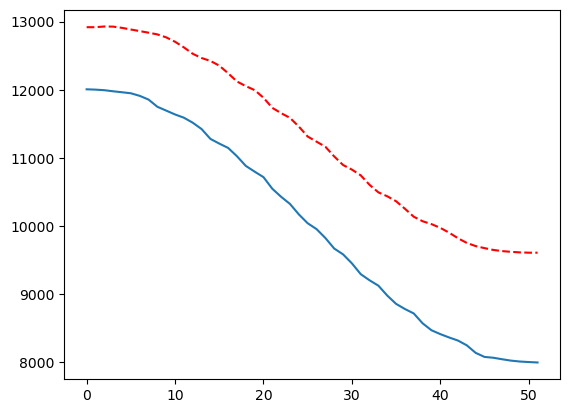

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f065cadc040>

In [36]:
figure()
plot(initial_topography)
plot(topography[end],"r--")

In [32]:
maximum(topography[1])-minimum(topography[1])



4005.0144734238283

In [ ]:
figure()
pcolor(vx)
colorbar()
show()

figure()
scatter(markers.x[1,1:markers.nmark],markers.x[2,1:markers.nmark],c=markers.scalars[markers.scalarFields["X"],1:markers.nmark])
show()

In [ ]:
min(0.1,1.0)